# XGBoost Starter — GPU (WSL2) Demo Notebook

This notebook mirrors the `train.py` + `predict.py` workflow in an **interactive**, beginner‑friendly way:

- Load a clean dataset (Breast Cancer from scikit‑learn).
- Train **XGBoost** with **early stopping** (ES), using GPU if available.
- Report **AUC** and **F1**, and plot a **ROC curve** (single plot).
- Show a simple **feature importance** bar chart (single plot).
- Save a model bundle (`xgb_model.joblib`) just like the scripts do.
- Run a small **prediction** example to illustrate how `predict.py` works.

> Tip: GitHub renders notebook **outputs** if they are committed to the repo.  
> Keep outputs reasonably small and deterministic for clean diffs.


## 1. Environment & Versions

We check the versions of Python and core libraries, and verify that the GPU is visible.


In [1]:
import sys, platform, subprocess, json, os
import numpy as np, pandas as pd

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

# Optional: show GPU via nvidia-smi if present (won't error if missing)
def try_cmd(cmd):
    try:
        out = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT, timeout=5)
        print(out.decode()[:500])
    except Exception as e:
        print(f"(Info) Command failed or unavailable: {cmd} -> {e}")

print("\n--- nvidia-smi (optional) ---")
try_cmd("nvidia-smi")


Python: 3.11.14
Platform: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35
NumPy: 2.3.4
Pandas: 2.3.3

--- nvidia-smi (optional) ---
Sun Nov  9 11:52:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|       


## 2. Imports and GPU/CPU Selection

We try to use **CUDA** if available; otherwise we fall back to CPU.  
This way the notebook is portable across environments.


In [3]:
import random, joblib, math
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import xgboost as xgb
from xgboost import XGBClassifier

# Reproducibility (good practice for demos + GitHub diffs)
SEED = 42
np.random.seed(SEED); random.seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)

# Decide device: prefer CUDA if present
def get_device():
    try:
        # If xgboost was built with GPU support, just try a tiny train on cuda
        dm = xgb.DMatrix(np.random.rand(50, 5), label=np.random.randint(0,2,50))
        xgb.train({"objective": "binary:logistic", "tree_method":"hist", "device":"cuda"}, dm, num_boost_round=1)
        return "cuda"
    except Exception as e:
        return "cpu"

DEVICE = get_device()
print("Using device:", DEVICE)


Using device: cuda


## 3. Load Data and Create Train/Validation Split

We use scikit‑learn's Breast Cancer dataset (small, tabular, binary classification).


In [4]:
data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
X.shape, X_tr.shape, X_va.shape


((569, 30), (455, 30), (114, 30))

## 4. Train XGBoost with Early Stopping

- We cap `n_estimators` high and rely on `early_stopping_rounds` to halt.
- We monitor **AUC** on the validation split.


In [8]:
clf = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    device=DEVICE,
    eval_metric="auc",
    early_stopping_rounds=200,
)

clf.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=50
)

print("Best iteration:", clf.best_iteration_ if hasattr(clf, "best_iteration_") else getattr(clf, "best_iteration", None))


[0]	validation_0-auc:0.99504
[50]	validation_0-auc:0.99372
[100]	validation_0-auc:0.99438
[150]	validation_0-auc:0.99537
[200]	validation_0-auc:0.99537
[201]	validation_0-auc:0.99537
Best iteration: 1


## 5. Report Metrics (AUC + F1)

We use a default threshold of **0.50** for F1. You can tune it later.


In [9]:
proba_va = clf.predict_proba(X_va)[:, 1]
preds_va = (proba_va >= 0.5).astype(int)

val_auc = roc_auc_score(y_va, proba_va)
val_f1  = f1_score(y_va, preds_va)

print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation F1 : {val_f1:.4f} (threshold=0.50)")


Validation AUC: 0.9975
Validation F1 : 0.7742 (threshold=0.50)


/home/myunix/miniconda3/envs/xgb-starter/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [12:11:37] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


## 6. Plot ROC Curve

One clean chart per figure (best practice for simple notebooks).

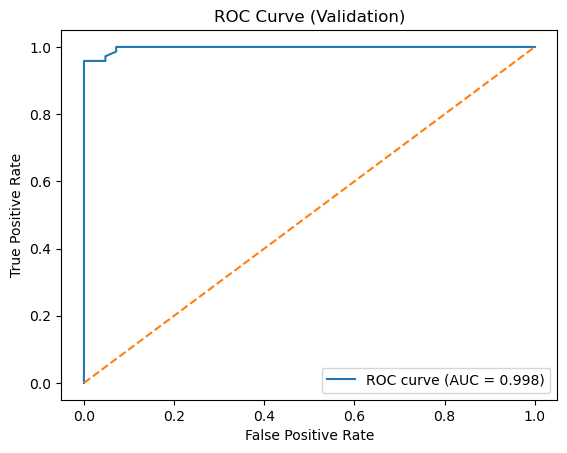

In [10]:
fpr, tpr, _ = roc_curve(y_va, proba_va)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation)')
plt.legend(loc="lower right")
plt.show()


## 7. Feature Importance (Gain)

Quick glance at which features contributed most (model-dependent heuristic).

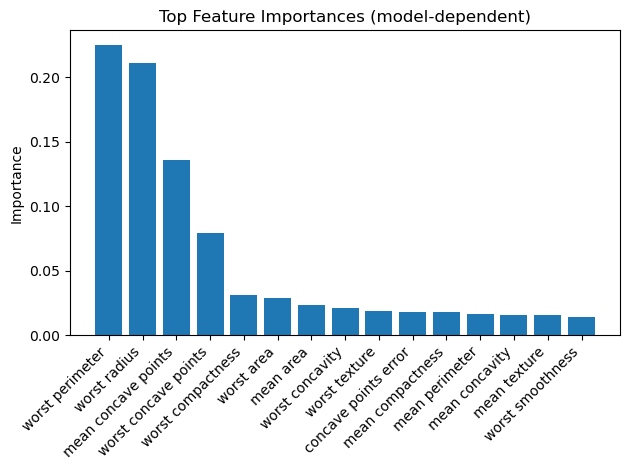

In [11]:
importances = clf.feature_importances_
order = np.argsort(importances)[::-1][:15]  # top-15 for readability

plt.figure()
plt.bar(range(len(order)), importances[order])
plt.xticks(range(len(order)), X.columns[order], rotation=45, ha='right')
plt.ylabel('Importance')
plt.title('Top Feature Importances (model-dependent)')
plt.tight_layout()
plt.show()


## 8. Save the Trained Model Bundle

We save the same structure used by `predict.py`: a dict with `model` + `feature_names`.


In [12]:
bundle = {"model": clf, "feature_names": X.columns.tolist()}
joblib.dump(bundle, "xgb_model.joblib")
print("Saved xgb_model.joblib")


Saved xgb_model.joblib


## 9. Mini Prediction Demo

We use a few validation rows to simulate reading a CSV, then produce predictions and probabilities.


In [13]:
demo = X_va.head(5).copy()
demo_path = "demo_input.csv"
demo.to_csv(demo_path, index=False)
print("Wrote", demo_path)

# Load bundle (like predict.py does)
loaded = joblib.load("xgb_model.joblib")
model = loaded["model"]
feature_names = loaded["feature_names"]

# Align and predict
demo2 = demo[feature_names]
proba = model.predict_proba(demo2)[:, 1]
pred  = (proba >= 0.5).astype(int)

import pandas as pd
out = pd.DataFrame({"prediction": pred, "proba": proba})
out_path = "predictions_demo.csv"
out.to_csv(out_path, index=False)
print("Wrote", out_path)
out


Wrote demo_input.csv
Wrote predictions_demo.csv


,prediction,proba
0,1,0.590177
1,1,0.647548
2,1,0.594640
3,1,0.615589
4,1,0.590177
